HighTime - Web traffic analysis neural model
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this assignment is to train a simple DNN model to make predictions over web traffic.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt

Let us mimic real traffic data by using normal distribution:

[ 11  15  32  54  93 114 178 261 333 425 449 530 499 457 397 319 262 214]


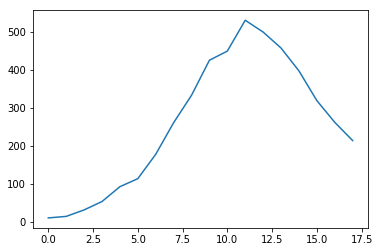

In [2]:
def fake_train(batch_size=24):
  assert batch_size > 0 and batch_size < 25
  normal = np.random.normal(12, 4, 5000)
  train = np.arange(batch_size)

  for i in range(0, batch_size):
    count = 0
    for p in normal:
      if (p >= i and p < i + 1):
        count += 1
    train[i] = count
  return train

example = fake_train(18)
print(example)

plt.plot(range(0, 18), example)
plt.show()

Function to generate a training batch:

In [3]:
class BatchGenerator(object):
  def __init__(self, feature_size, batch_size):
    self._batch_size = batch_size
    self._feature_size = feature_size

  def spit(self):
    labels = fake_train(self._batch_size).reshape([self._batch_size, 1])
    train = np.zeros((self._batch_size, self._feature_size), dtype=np.float32)
    np.fill_diagonal(train, 1)

    return train, labels

Generate valid and test datasets:

In [4]:
feature_size = 24 # 24 hours per day

generator = BatchGenerator(feature_size, 24)

valid_dataset, valid_labels = generator.spit()
test_dataset, test_labels = generator.spit()

np.set_printoptions(formatter={'float': '{0:g}'.format})
for vector, label in list(zip(test_dataset, test_labels)):
  print('data (hour) = %s => %d rps' % (vector, label))

data (hour) = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 9 rps
data (hour) = [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 23 rps
data (hour) = [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 25 rps
data (hour) = [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 43 rps
data (hour) = [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 105 rps
data (hour) = [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 142 rps
data (hour) = [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 194 rps
data (hour) = [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 256 rps
data (hour) = [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 314 rps
data (hour) = [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => 405 rps
data (hour) = [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] => 448 rps
data (hour) = [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] => 517 rps
data (hour) = [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] => 524 rps
data (hour) = [0 0 0 0 0 0 0 0

Simple NN Model.

In [5]:
num_labels = 1 # label dimension
batch_size = 18
learning_rate = 0.5

graph = tf.Graph()
with graph.as_default():
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  X = tf.placeholder(tf.float32, shape=(batch_size, feature_size))
  Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))

  tf_test_dataset = tf.constant(test_dataset)
  predict_data = tf.placeholder(tf.float32, shape=(num_labels, feature_size))

  # Variables.
  weights = tf.Variable(tf.ones([feature_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  y = tf.matmul(X, weights) + biases
  loss = tf.reduce_mean(tf.square(y - Y))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Predictions for the training, test and real data.
  train_prediction = y
  test_prediction = tf.matmul(tf_test_dataset, weights) + biases
  prediction = tf.matmul(predict_data, weights) + biases

In [20]:
num_steps = 1001
generator = BatchGenerator(feature_size, batch_size)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

session = tf.Session(graph=graph)

with graph.as_default():
  with session.as_default():
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
      batch_data, batch_labels = generator.spit()
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {X : batch_data, Y : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 50 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
  #       print("Validation accuracy: %.1f%%" % accuracy(
  #         valid_prediction.eval(), valid_labels))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 95823.218750
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 50: 249.997177
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 100: 228.803894
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 150: 287.294647
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 200: 290.885620
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 250: 442.346741
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 300: 597.037231
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 350: 212.155167
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 400: 188.232941
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 450: 196.081665
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at step 500: 210.015778
Minibatch accuracy: 100.0%
Test accuracy: 100.0%
Minibatch loss at ste

Let us check it out

In [26]:
to_predict = np.zeros(feature_size)
to_predict[2] = 1
print(to_predict)
data_to_predict = to_predict.reshape(1, feature_size)
print(data_to_predict)

with session.as_default():
  print(prediction.eval(feed_dict={predict_data : data_to_predict}))
  print(weights.eval(), biases.eval())

# with tf.Session(graph=graph) as session:
#   tf.global_variables_initializer().run()
#   print("Initialized")

#   feed_dict = {predict_data : data_to_predict}
#   real_prediction = session.run(prediction, feed_dict=feed_dict)
# #   print(real_prediction)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[30.4819]]
[[-236.781]
 [-227.074]
 [-213.407]
 [-191.762]
 [-156.939]
 [-113.058]
 [-50.7223]
 [20.6672]
 [93.8648]
 [169.288]
 [219.509]
 [246.284]
 [247.545]
 [225.996]
 [164.54]
 [95.4364]
 [19.7463]
 [-51.2459]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]] [243.889]
